In [1]:
import random

import pandas as pd

from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.preprocessing.filters import Filters
from ptrail.preprocessing.interpolation import Interpolation
from ptrail.features.temporal_features import TemporalFeatures

"""
    So what I am planning to do for this notebook is that we will
    first try to perform classification of Species of the Starkey
    dataset using the original dataset only and plot it using
    matplotlib and see what the results look like.

    Next, we will use PTRAIL to generate features on the starkey
    dataset and then we will again perform the same kind of
    classification performed above to see the difference and how
    the features generated by us help in making the classification
    process better.
"""

pdf = pd.read_csv('./starkey_new.csv')
starkey = PTRAILDataFrame(data_set=pdf,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print(starkey)

------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


In [2]:
%%time

# Now applying a full pipeline of feature generation and data cleanup
# using PTRAIL.

# 1. Create a distance column based on which we will remove
# outlier using hampel filter.
starkey = KinematicFeatures.create_distance_column(dataframe=starkey)

# 2. Applying hampel filter.
filt_starkey = Filters.hampel_outlier_detection(dataframe=starkey,
                                                column_name='Distance')

# 3. Now, interpolate the trajectories using linear Interpolation.
ip_starkey = Interpolation.interpolate_position(dataframe=filt_starkey,
                                                time_jump=3600*2,
                                                ip_type='linear')

# 4. Now, generate kinematic and temporal features on the
# interpolated dataset.
feat_starkey = KinematicFeatures.generate_kinematic_features(dataframe=ip_starkey)
feat_starkey = TemporalFeatures.generate_temporal_features(dataframe=feat_starkey)

/home/yjharanwala/Desktop/PTRAIL/ptrail/preprocessing/filters.py:762: UserWarning: If kinematic features have been generated on the dataframe, then make sure to generate them again as outlier detection drops the point from the dataframe and does not run the kinematic features again.
  warnings.warn("If kinematic features have been generated on the dataframe, then make "


CPU times: user 7.67 s, sys: 1.2 s, total: 8.87 s
Wall time: 1min 14s


In [3]:
# Now, we create test and train datasets. The train dataset includes
# 33% of all the unique trajectories in the dataset and the test
# contains the rest.
import random
import progressbar
import datetime as dt

def dtt2timestamp(dtt):
    ts = (dtt.hour * 60 + dtt.minute) * 60 + dtt.second
    #if you want microseconds as well
    ts += dtt.microsecond * 10**(-6)
    return ts

In [4]:
taken = []
train_33 = []
test_66 = []

total = feat_starkey.traj_id.unique().tolist()
len(total)

iterator = 0
while iterator != len(total)//3:
    index = random.randint(0, len(total))
    if index not in taken:
        train_33.append(total[index])
        taken.append(index)
        iterator += 1

for i in range(len(total)):
    if total[i] not in train_33:
        test_66.append(total[i])

print(len(test_66))
print(len(train_33))

169
84


In [5]:
test_chunks = []

bar = progressbar.ProgressBar(max_value=progressbar.UnknownLength)
for i in range(len(test_66)):
    small = feat_starkey.reset_index().loc[feat_starkey.reset_index().traj_id == test_66[i]]

    if 'D' in test_66[i]:
        small['Species'] = 0
    elif 'E' in test_66[i]:
        small['Species'] = 1
    else:
        small['Species'] = 2

    small['Date'] = small['Date'].map(dt.datetime.toordinal)
    small['Time'] = small['Time'].apply(dtt2timestamp)
    small = small.drop(columns=['Day_Of_Week', 'Time_Of_Day'])

    test_chunks.append(small)
    bar.update(i)

test_df = PTRAILDataFrame(data_set=pd.concat(test_chunks).dropna(),
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')

/ |                                               # | 168 Elapsed Time: 0:00:24

In [6]:
train_chunks = []

bar = progressbar.ProgressBar(max_value=progressbar.UnknownLength)
for i in range(len(train_33)):
    small = feat_starkey.reset_index().loc[feat_starkey.reset_index().traj_id == train_33[i]]

    if 'D' in train_33[i]:
        small['Species'] = 0
    elif 'E' in train_33[i]:
        small['Species'] = 1
    else:
        small['Species'] = 2
    small['Date'] = small['Date'].map(dt.datetime.toordinal)
    small['Time'] = small['Time'].apply(dtt2timestamp)
    small = small.drop(columns=['Day_Of_Week', 'Time_Of_Day'])

    train_chunks.append(small)
    bar.update(i)

train_df = PTRAILDataFrame(data_set=pd.concat(train_chunks).dropna(),
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')

| |                   #                              | 83 Elapsed Time: 0:00:11

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier()
rf_model.fit(train_df.drop(columns=['Species']),
             train_df['Species'])

RandomForestClassifier()

In [8]:
# Now, lets predict the Species on the train and test dataset.
rf_predict_train = rf_model.predict(train_df.drop(columns=['Species']))
print(f"Target on train data: {rf_predict_train}")

rf_predict_test = rf_model.predict(test_df.drop(columns=['Species']))
print(f"Target on test data: {rf_predict_test}")

Target on train data: [0 0 0 ... 2 2 2]
Target on test data: [0 0 0 ... 1 1 1]


In [9]:
report = classification_report(y_true=test_df['Species'],
                               y_pred=rf_predict_test,
                               target_names=['Deer', 'Elk', 'Cattle'])
print(report)

              precision    recall  f1-score   support

        Deer       0.67      0.38      0.49     68250
         Elk       0.75      0.85      0.80    141369
      Cattle       0.72      0.94      0.81     34755

    accuracy                           0.73    244374
   macro avg       0.71      0.72      0.70    244374
weighted avg       0.72      0.73      0.71    244374



In [41]:
from sklearn.decomposition import SparsePCA

ids_ = ['880109D01',  '900626E01', 'OSUX91121']
small = test_df.loc[test_df.index.get_level_values('traj_id').isin(ids_)]
pca = SparsePCA(n_components=2)
X_embedded = pca.fit_transform(small)

/home/yjharanwala/anaconda3/envs/PreprocessingLibrary/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

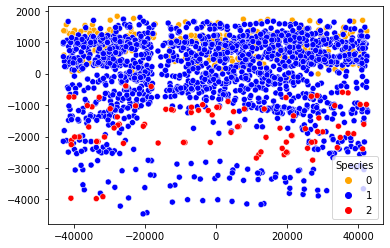

In [42]:
import seaborn as sns

sns.scatterplot(X_embedded[:, 0],
                X_embedded[:, 1],
                legend='full',
                hue=small['Species'],
                palette=['orange', 'blue', 'red'])